In [130]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np
import statsmodels.api as sm 
import scipy
import math
from sklearn.metrics import mean_squared_error

In [131]:
df = pd.read_csv('weatherAUS.csv', index_col=0, parse_dates=True)

In [132]:
df.head()

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow
Date,,,,,,,,,,,,,,,,,,,,,
2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,...,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,0.0,No
2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,...,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,0.0,No
2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,...,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,0.0,No
2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,...,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,1.0,No
2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,...,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,0.2,No


1. Teil: Bivariate Analyse

In [133]:
df["MaxTemp"].interpolate(inplace=True)

In [134]:
df = df[df.Location == "Sydney"]
df.isna().sum()

Location            0
MinTemp             3
MaxTemp             0
Rainfall            6
Evaporation        51
Sunshine           16
WindGustDir      1036
WindGustSpeed    1036
WindDir9am         56
WindDir3pm         33
WindSpeed9am       26
WindSpeed3pm       25
Humidity9am        14
Humidity3pm        13
Pressure9am        20
Pressure3pm        19
Cloud9am          566
Cloud3pm          561
Temp9am             4
Temp3pm             4
RainToday           6
RISK_MM             0
RainTomorrow        0
dtype: int64

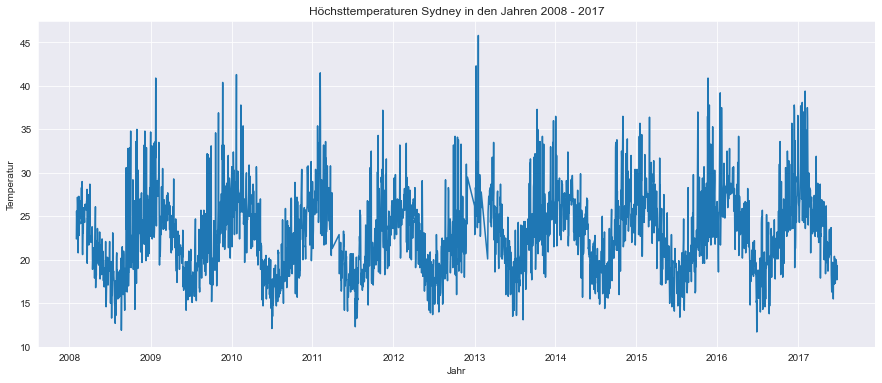

In [135]:
sns.set_style('darkgrid')
plt.figure(figsize=[15,6])
plt.plot(df["MaxTemp"])
plt.xlabel("Jahr")
plt.ylabel("Temperatur")
plt.title("Höchsttemperaturen Sydney in den Jahren 2008 - 2017")
plt.show()

In [136]:
monthly_mean = df.groupby(df.index.month).aggregate("mean")["MaxTemp"]

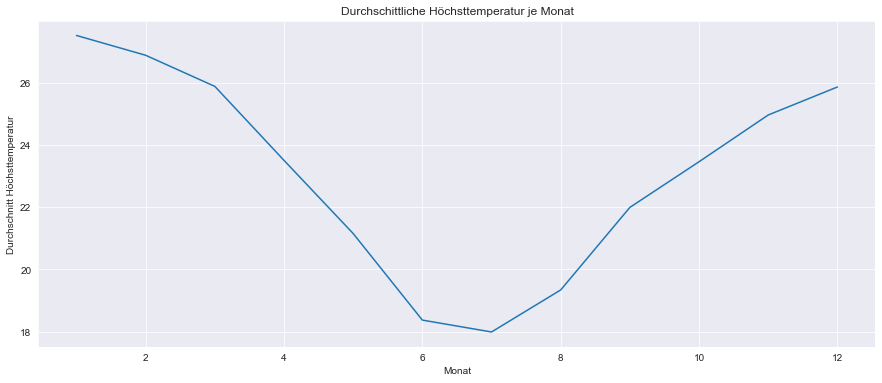

In [137]:
plt.figure(figsize=[15,6])
plt.plot(monthly_mean)
plt.xlabel("Monat")
plt.ylabel("Durchschnitt Höchsttemperatur")
plt.title("Durchschittliche Höchsttemperatur je Monat")
plt.show()

starke Saisonalität! 

Saisonbereinigung der Zeitreihe durch Bilden von Inkrementen:

In [138]:
inc = df['MaxTemp'].diff()

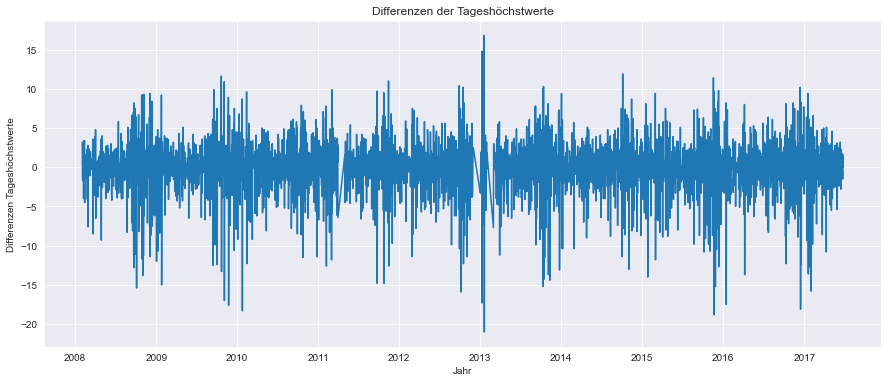

In [139]:
plt.figure(figsize=[15,6])
plt.plot(inc)
plt.xlabel("Jahr")
plt.ylabel("Differenzen Tageshöchstwerte")
plt.title("Differenzen der Tageshöchstwerte")
plt.show()

Zwar Saison rausbekommen, jedoch starkes Clustering in der Varianz: nicht stationär -> notwenige Bedingung für EWMA

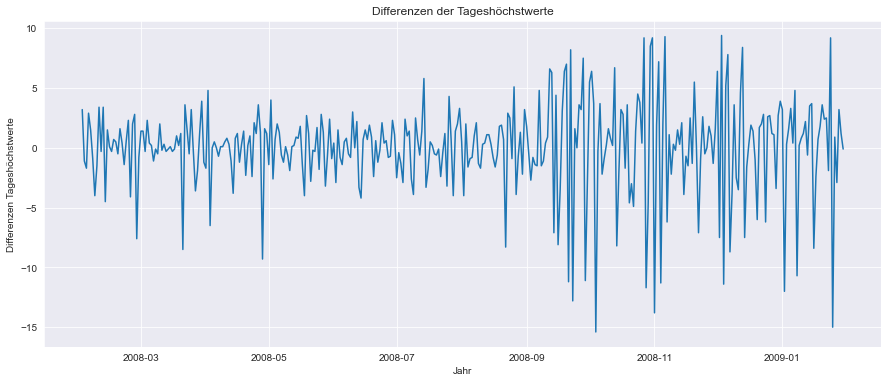

In [140]:
plt.figure(figsize=[15,6])
plt.plot(inc[:365])
plt.xlabel("Jahr")
plt.ylabel("Differenzen Tageshöchstwerte")
plt.title("Differenzen der Tageshöchstwerte")
plt.show()

In [141]:
df_ewma = pd.DataFrame()

In [142]:
df_ewma["MaxTemp"] = df["MaxTemp"]
df_ewma["inc"] = inc
df_ewma.drop(df_ewma.head(1).index, inplace=True)

In [143]:
df_ewma = df_ewma.iloc[200:,]

In [144]:
df_ewma["MaxTemp"][0]

19.5

In [145]:
df_ewma.iloc[1:,:].inc.isna().sum()

0

In [146]:
alpha = 0.5
a_pred = []
a_pred.append(df_ewma["inc"][0])
for i in range(len(df_ewma["inc"])):
    a_neu = alpha*df_ewma["inc"][i]+(1-alpha)*a_pred[i]
    a_pred.append(a_neu)

In [147]:
df_ewma["ewmas"] = a_pred[1:]

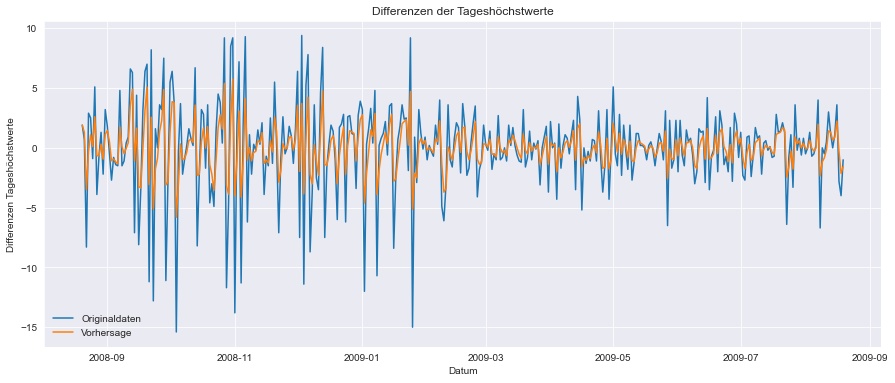

In [148]:
plt.figure(figsize=[15,6])
plt.plot(df_ewma["inc"][:365], label = "Originaldaten")
plt.plot(df_ewma["ewmas"][:365], label = "Vorhersage")
plt.xlabel("Datum")
plt.ylabel("Differenzen Tageshöchstwerte")
plt.title("Differenzen der Tageshöchstwerte")
plt.legend(loc='lower left', frameon=False)
plt.show()

In [149]:
df_ewma["MaxTemp_ewma"] = np.r_[df_ewma["MaxTemp"].iloc[0], df_ewma["ewmas"].iloc[1:]].cumsum()

In [150]:
df_ewma

,MaxTemp,inc,ewmas,MaxTemp_ewma
Date,,,,
2008-08-20,19.5,1.9,1.900000,19.500000
2008-08-21,20.2,0.7,1.300000,20.800000
2008-08-22,11.9,-8.3,-3.500000,17.300000
2008-08-23,14.8,2.9,-0.300000,17.000000
2008-08-24,17.3,2.5,1.100000,18.100000
...,...,...,...,...
2017-06-21,19.6,-0.4,0.220037,21.279963
2017-06-22,19.2,-0.4,-0.089981,21.189981
2017-06-23,17.7,-1.5,-0.794991,20.394991


In [151]:
math.sqrt(mean_squared_error(df_ewma["MaxTemp"],df_ewma["MaxTemp_ewma"]))

2.499983667379838

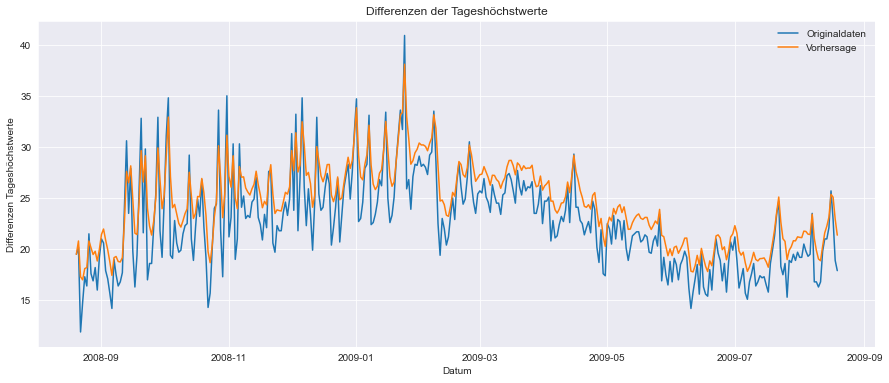

In [153]:
plt.figure(figsize=[15,6])
plt.plot(df_ewma["MaxTemp"][:365], label = "Originaldaten")
plt.plot(df_ewma["MaxTemp_ewma"][:365], label = "Vorhersage")
plt.xlabel("Datum")
plt.ylabel("Differenzen Tageshöchstwerte")
plt.title("Differenzen der Tageshöchstwerte")
plt.legend(loc='upper right', frameon=False)
plt.show()
plt.show()

2. Teil Multivariate Analyse: Polynomiale Regression

In [41]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

a) Untersuchung der Korrelationen

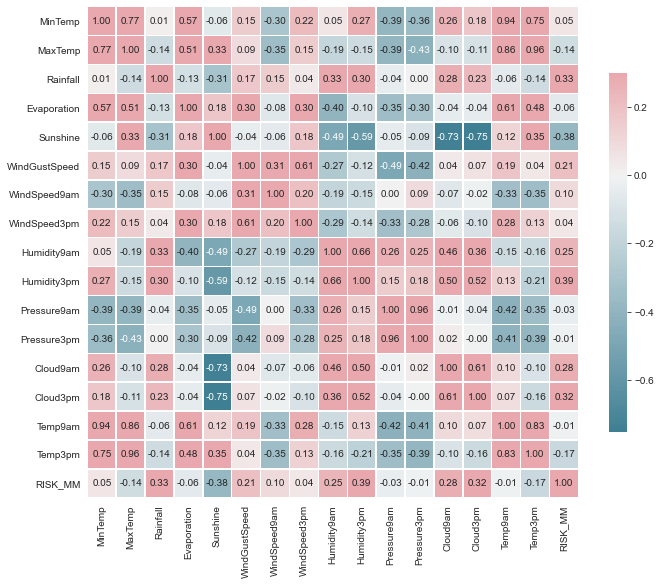

In [42]:
plt.subplots(figsize=(11,11))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(df.corr(),vmax=.3, annot=True,center=0, cmap=cmap, fmt='.2f',
            square=True, linewidths=.5, cbar_kws={"shrink": .6});


b) Untersuchung der Cross-Korrelationen

In [43]:
df["Evaporation"].interpolate(inplace=True)
df["Humidity3pm"].interpolate(inplace=True)
df["Sunshine"].interpolate(inplace=True)
df["Pressure3pm"].interpolate(inplace=True)

<ipython-input-43-a5bfec38e365>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Evaporation"].interpolate(inplace=True)
<ipython-input-43-a5bfec38e365>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Humidity3pm"].interpolate(inplace=True)
<ipython-input-43-a5bfec38e365>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Sunshine"].interpolate(inplace=True)
<ipython-input-43-a5bfec38e365>:4: SettingWithCopyWarning: 
A value

* Anhand ACF Entschiedung treffen, dass die Temperatur vor 2 Tagen eine gute Inputgröße ist 

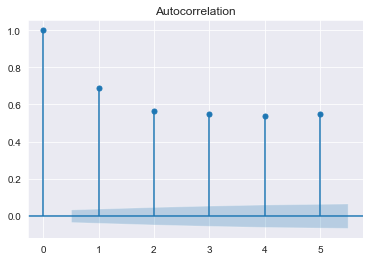

<Figure size 1080x432 with 0 Axes>

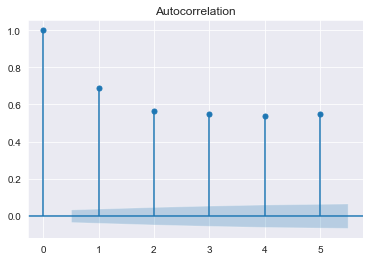

In [44]:
sns.set_style('darkgrid')
plt.figure(figsize=[15,6])
sm.graphics.tsa.plot_acf(df["MaxTemp"], lags=5)

In [45]:
np.corrcoef(df["MaxTemp"][2:], df["MaxTemp"].shift(1)[2:])

array([[1.        , 0.68816142],
       [0.68816142, 1.        ]])

In [46]:
df2 = pd.DataFrame()
df2["MaxTemp"] = df["MaxTemp"]
df2["Max_Temp_2lag"] = df["MaxTemp"].shift(2)
df2["Humidity3pm_2lag"] = df["Humidity3pm"].shift(2)
df2["Sunshine_2lag"] = df["Sunshine"].shift(2)
df2["Pressure3pm_2lag"] = df["Pressure3pm"].shift(2)
df2["Evaporation_2lag"] = df["Evaporation"].shift(2)

df2.dropna(inplace=True)

In [154]:
df2.head()

,Max_Temp_2lag,Humidity3pm_2lag,Sunshine_2lag,Pressure3pm_2lag,Evaporation_2lag
Date,,,,,
2008-02-03,22.4,84.0,0.0,1017.4,6.2
2008-02-04,25.6,73.0,2.7,1016.4,3.4
2008-02-05,24.5,86.0,0.1,1015.6,2.4
2008-02-06,22.8,90.0,0.0,1011.8,2.2
2008-02-07,25.7,74.0,0.0,1004.8,2.4


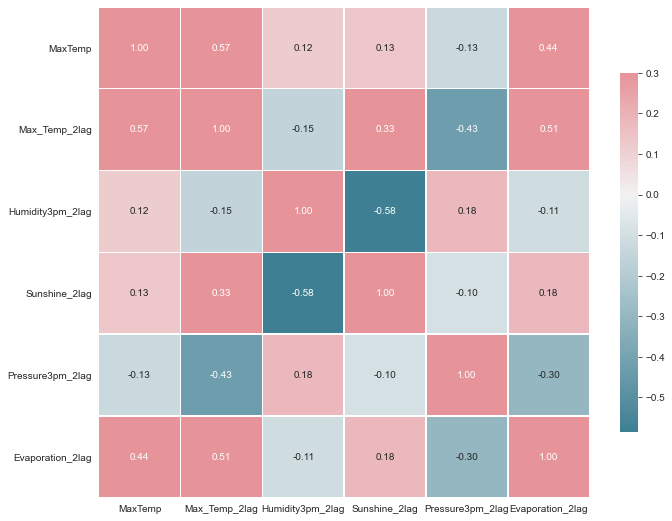

In [48]:
plt.subplots(figsize=(11,11))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(df2.corr(),vmax=.3, annot=True,center=0, cmap=cmap, fmt='.2f',
            square=True, linewidths=.5, cbar_kws={"shrink": .6});

In [50]:
y=df2.pop('MaxTemp').values
X = df2
train_size = int(len(X) * 0.75)
X_train, X_test, y_train, y_test = X[:train_size], X[train_size:], y[:train_size], y[train_size:]
print('Observations: %d' % (len(X)))
print('Training Observations: %d' % (len(X_train)))
print('Testing Observations: %d' % (len(X_test)))

Observations: 3335
Training Observations: 2501
Testing Observations: 834


In [51]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [54]:
preds_df = pd.DataFrame()

In [55]:
preds_df["MaxTemp"] = df.MaxTemp[:834]

(834, 1)

In [57]:
import statsmodels.api as sm

In [58]:
X_train = sm.add_constant(X_train)

In [59]:
model = sm.OLS(y_train, X_train).fit()

In [60]:
X_test = sm.add_constant(X_test)

In [61]:
preds_statsmodels = model.predict(X_test)

In [62]:
preds_df["preds_statsmodels"] = preds_statsmodels

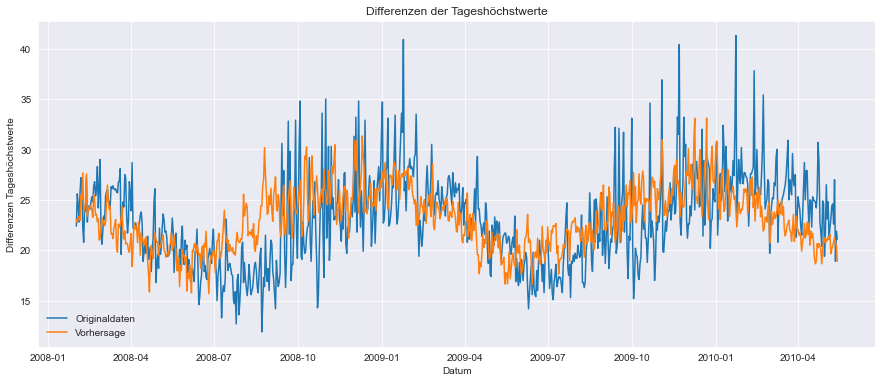

In [63]:
plt.figure(figsize=[15,6])
plt.plot(preds_df["MaxTemp"], label = "Originaldaten")
plt.plot(preds_df["preds_statsmodels"], label = "Vorhersage")
plt.xlabel("Datum")
plt.ylabel("Differenzen Tageshöchstwerte")
plt.title("Differenzen der Tageshöchstwerte")
plt.legend(loc='lower left', frameon=False)
plt.show()

In [64]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.400
Model:                            OLS   Adj. R-squared:                  0.399
Method:                 Least Squares   F-statistic:                     332.7
Date:                Wed, 04 Aug 2021   Prob (F-statistic):          1.43e-273
Time:                        20:05:12   Log-Likelihood:                -6627.2
No. Observations:                2501   AIC:                         1.327e+04
Df Residuals:                    2495   BIC:                         1.330e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         22.8716      0.069    333.634      0.0

In [65]:
y_train.shape

(2501,)

In [66]:
X_train.shape

(2501, 6)

In [67]:
#############################

In [70]:
math.sqrt(mean_squared_error(preds_df["preds_statsmodels"],preds_df["MaxTemp"]))

4.187751778114447

Monat als EInflussgröße? Polynomiales Modell

In [107]:
from sklearn.preprocessing import PolynomialFeatures

In [116]:
poly = PolynomialFeatures(degree=2)

In [117]:
X_train.shape

(2501, 6)

In [118]:
X_train_poly = poly.fit_transform(X_train)

In [119]:
X_train_poly.shape

(2501, 210)

In [120]:
model2 = sm.OLS(y_train, X_train_poly).fit()

In [121]:
preds_statsmodels2 = model2.predict(poly.fit_transform(X_test))
preds_df["preds_statsmodels2"] = preds_statsmodels2

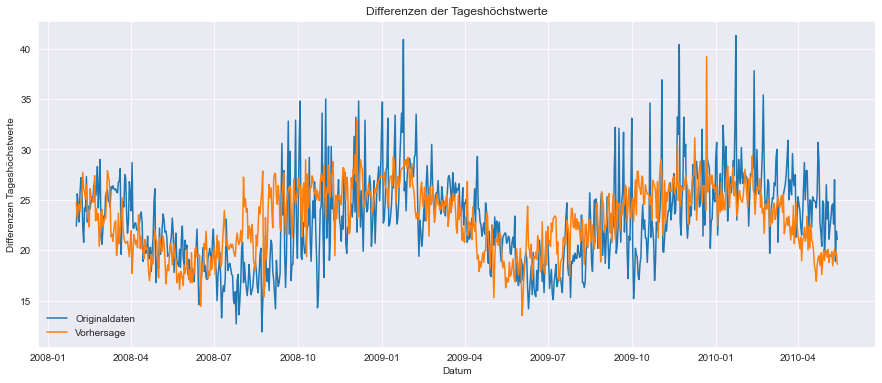

In [122]:
plt.figure(figsize=[15,6])
plt.plot(preds_df["MaxTemp"], label = "Originaldaten")
plt.plot(preds_df["preds_statsmodels2"], label = "Vorhersage")
plt.xlabel("Datum")
plt.ylabel("Differenzen Tageshöchstwerte")
plt.title("Differenzen der Tageshöchstwerte")
plt.legend(loc='lower left', frameon=False)
plt.show()

In [123]:
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.497
Model:                            OLS   Adj. R-squared:                  0.470
Method:                 Least Squares   F-statistic:                     18.75
Date:                Wed, 04 Aug 2021   Prob (F-statistic):          2.79e-268
Time:                        20:27:11   Log-Likelihood:                -6407.5
No. Observations:                2501   AIC:                         1.307e+04
Df Residuals:                    2375   BIC:                         1.380e+04
Df Model:                         125                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.7117      0.051     92.974      0.0

In [124]:
math.sqrt(mean_squared_error(preds_df["preds_statsmodels2"],preds_df["MaxTemp"]))

4.148392342272497